In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import io

import glob
import os

# Model training comparison with a ground truth (entire slice manually segmented)

In [2]:
path_data = "C:\\Users\\lauri\\OneDrive - Danmarks Tekniske Universitet\\Dokumenter\\GitHub\\segmenter\\notebooks"

In [3]:
os.chdir(path_data)

In [4]:
os.listdir()

['6501045458.zip',
 'Data_comparison.ipynb',
 'Data_comparison_2.ipynb',
 'Examine in progress.ipynb',
 'Explore Data.ipynb',
 'human_progress.png',
 'lno_annotations.png',
 'MakeFigures.ipynb',
 'Manual_segmentation.csv',
 'output_5272987912_s1093',
 'output_5272987912_s1507',
 'output_5272987912_s724',
 'output_6501045458_s1093',
 'output_6501045458_s1507',
 'output_6501045458_s724',
 'Presentation figures.ipynb',
 'QJ2_25nm_bas_v1_01093.tif',
 'QJ2_25nm_bas_v1_01093_correcMan.tif',
 'Repeat annotation.ipynb',
 'Results.ipynb',
 'rough.tif',
 'Rough_segmentation.csv',
 'segmentation_comparison.png',
 'Setup_annotation_01.jpeg',
 'Setup_annotation_02.jpeg',
 'Setup_annotation_03.jpeg',
 'trained.tif',
 'trained_2.tif',
 'Trained_segmentation.csv',
 'voltif_Gr_extracts']

In [5]:
image_initial = io.imread("QJ2_25nm_bas_v1_01093.tif")
image_manual = io.imread("QJ2_25nm_bas_v1_01093_correcMan.tif")
image_rough = io.imread("rough.tif")
image_trained = io.imread("trained_2.tif")

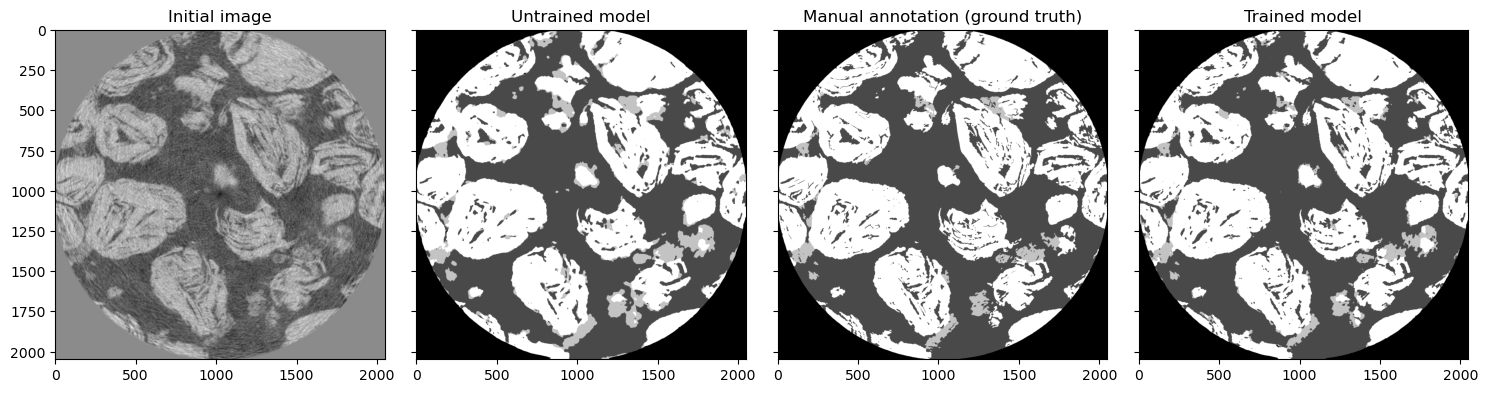

In [6]:
# Global visualistaion of the initial image and the outputs from the three segmentations
fig1, axes1 = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
axes1[0].imshow(image_initial, cmap="gray", interpolation=None)
axes1[0].set_title("Initial image")
axes1[1].imshow(image_rough, cmap="gray", interpolation=None)
axes1[1].set_title("Untrained model")
axes1[2].imshow(image_manual, cmap="gray", interpolation=None)
axes1[2].set_title("Manual annotation (ground truth)")
axes1[3].imshow(image_trained, cmap="gray", interpolation=None)
axes1[3].set_title("Trained model")
plt.tight_layout()
plt.show()

In [7]:
# Gathering pixel counts for phase fraction estimations
def get_pixel_count(image):
    greyLevel_values = np.unique(image)
    data = {}
    count = []
    global_count = 0
    for value in greyLevel_values:
        temp = (image==value).sum()
        count.append(temp)
        global_count += temp
#         print(value, count, global_count)
    assert global_count == image.size, "Warning, gloabal count does not match total number of pixels in the image."
    data["value"], data["pixel count"] = greyLevel_values, np.array(count)
    return data

data_manual = get_pixel_count(image_manual)
data_rough = get_pixel_count(image_rough)
data_trained = get_pixel_count(image_trained)

In [8]:
def get_dice_score_no_outside(image1, image2):
    assert image1.shape == image2.shape, "Warning, images must have the same shape."
    classes = np.unique(image1)
    print(classes)
    num_classes = len(classes)
    dice_score = np.zeros(num_classes)
    for i in range(num_classes):
        if classes[i] != 26:
            dice_score[i] = 2* ((image1 == classes[i] )& (image2 == classes[i])).sum() / ((image1 == classes[i]).sum() + (image2 == classes[i]).sum())
    return dice_score.sum() / (num_classes-1)


In [9]:
def get_dice_score(image1, image2):
    assert image1.shape == image2.shape, "Warning, images must have the same shape."
    classes = np.unique(image1)
    print(classes)
    num_classes = len(classes)
    dice_score = np.zeros(num_classes)
    for i in range(num_classes):

        dice_score[i] = 2* ((image1 == classes[i] )& (image2 == classes[i])).sum() / ((image1 == classes[i]).sum() + (image2 == classes[i]).sum())
    return dice_score.mean()


In [10]:
get_dice_score(image_manual, image_rough)

[ 26  89 191 242]


0.8315588922412673

In [11]:
get_dice_score(image_manual, image_trained)

[ 26  89 191 242]


0.8942859095564419

In [12]:
get_dice_score(image_manual, image_trained)

[ 26  89 191 242]


0.8942859095564419

In [13]:
# Get phase fractions
# Label 26 does not count in phase fractions => Not actual material ("outside" later)

labels_to_avoid = [26]

def get_phase_fractions(data, labels_to_avoid):
    total_count = 0
    for value in data["value"]:
        if value in labels_to_avoid:
            pass
        else:
            total_count += data["pixel count"][data["value"]==value]
    phase_fractions = []
    for value in data["value"]:
        if value in labels_to_avoid:
            phase_fractions.append(0.)
        else:
            phase_fractions.append(float(data["pixel count"][data["value"]==value]/total_count))
    test = np.array(phase_fractions).sum()
    assert test == 1, "Warning, phase fractions do not account to 1 in total: {}".format(test)
    data["phase fraction"] = np.array(phase_fractions)
    
get_phase_fractions(data_manual, labels_to_avoid)
get_phase_fractions(data_rough, labels_to_avoid)
get_phase_fractions(data_trained, labels_to_avoid)

C:\Users\lauri\AppData\Local\Temp\ipykernel_7804\4153012138.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phase_fractions.append(float(data["pixel count"][data["value"]==value]/total_count))


C:\Users\lauri\AppData\Local\Temp\ipykernel_7804\1945230305.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels=["Porosity - {:.2%}".format(float(data_rough["phase fraction"][data_rough["value"]==89])),
C:\Users\lauri\AppData\Local\Temp\ipykernel_7804\1945230305.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "Conductive binder - {:.2%}".format(float(data_rough["phase fraction"][data_rough["value"]==191])),
C:\Users\lauri\AppData\Local\Temp\ipykernel_7804\1945230305.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your ar

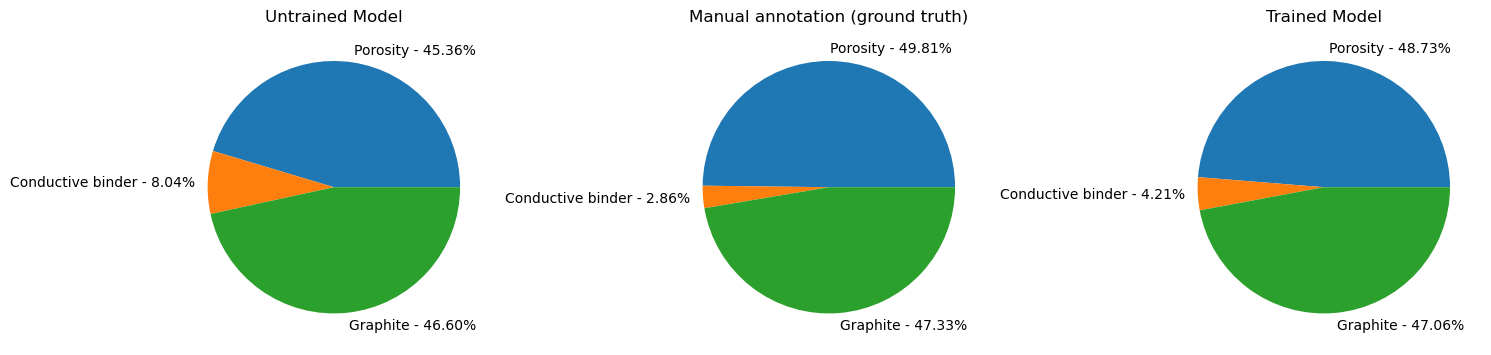

In [14]:
# Phase reparition per segmentation
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 10))
pp1 = axes2[0].pie(data_rough["phase fraction"][data_rough["value"]!=26], 
                   labels=["Porosity - {:.2%}".format(float(data_rough["phase fraction"][data_rough["value"]==89])),
                           "Conductive binder - {:.2%}".format(float(data_rough["phase fraction"][data_rough["value"]==191])),
                           "Graphite - {:.2%}".format(float(data_rough["phase fraction"][data_rough["value"]==242]))])
axes2[0].set_title("Untrained Model")
axes2[1].pie(data_manual["phase fraction"][data_manual["value"]!=26],
             labels=["Porosity - {:.2%}".format(float(data_manual["phase fraction"][data_manual["value"]==89])),
                     "Conductive binder - {:.2%}".format(float(data_manual["phase fraction"][data_manual["value"]==191])),
                     "Graphite - {:.2%}".format(float(data_manual["phase fraction"][data_manual["value"]==242]))])
axes2[1].set_title("Manual annotation (ground truth)")
axes2[2].pie(data_trained["phase fraction"][data_trained["value"]!=26], 
             labels=["Porosity - {:.2%}".format(float(data_trained["phase fraction"][data_trained["value"]==89])),
                     "Conductive binder - {:.2%}".format(float(data_trained["phase fraction"][data_trained["value"]==191])),
                     "Graphite - {:.2%}".format(float(data_trained["phase fraction"][data_trained["value"]==242]))])
axes2[2].set_title("Trained Model")
plt.tight_layout()
plt.show()

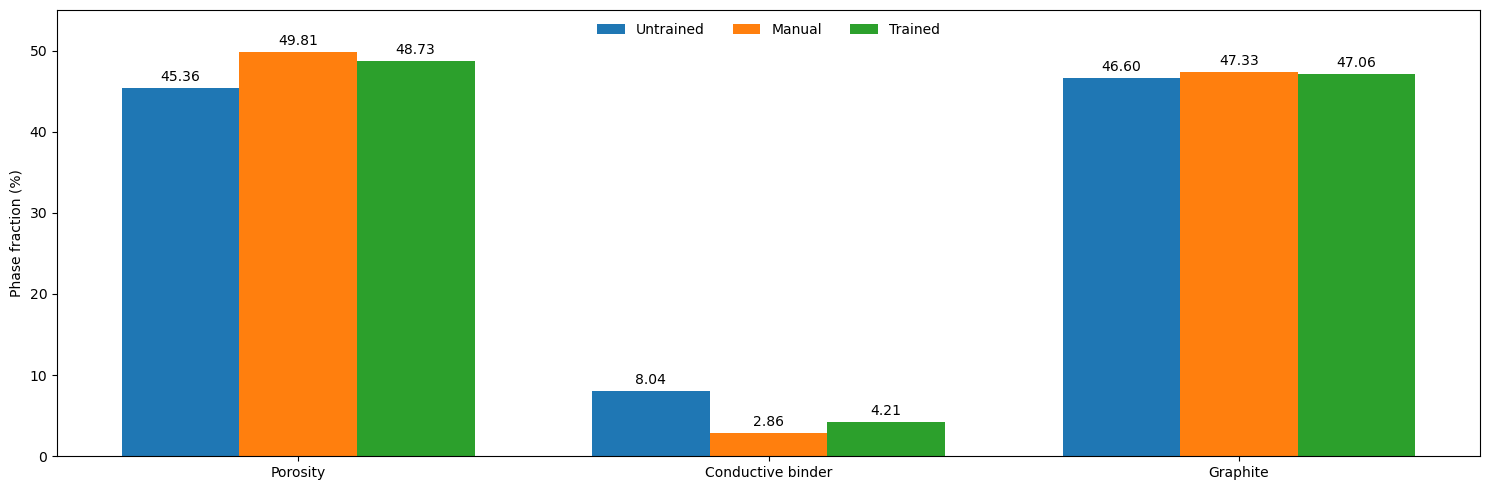

In [15]:
# phase fractions per phase depending on the segmentation
phases = ["Porosity", "Conductive binder", "Graphite"]
segmentations = {"Untrained": data_rough["phase fraction"][data_rough["value"]!=26]*100,
                 "Manual": data_manual["phase fraction"][data_manual["value"]!=26]*100,
                 "Trained": data_trained["phase fraction"][data_trained["value"]!=26]*100}

fig3, axes3 = plt.subplots(figsize=(15, 5))

x = np.arange(len(phases))
width = 0.25
multiplier = 0

for attribute, measurement in segmentations.items():
    offset = width * multiplier
    rects = axes3.bar(x + offset, measurement, width, label=attribute)
    axes3.bar_label(rects, fmt="%.2f", padding=3)
    multiplier += 1

axes3.set_ylabel("Phase fraction (%)")
axes3.set_xticks(x + width, phases)
axes3.legend(loc=9, ncol=3, frameon=False)
axes3.set_ylim(0, 55)
plt.tight_layout()
plt.show()

In [16]:
# Differences comming from wrongly segmenting the "outside" => not actual material
out_manual = float(data_manual["pixel count"][data_manual["value"]==26])
out_rough = float(data_rough["pixel count"][data_rough["value"]==26])
out_trained = float(data_trained["pixel count"][data_trained["value"]==26])

relative_difference_rough = (out_rough - out_manual) / out_manual
relative_difference_trained = (out_trained - out_manual) / out_manual
relative_difference_training = (out_rough - out_trained) / out_trained

print("""Relative differences comming from wrongly labelling the outside area in the images (not actual material):
- Regarding the "outside label":
    Untrained model vs. manual segmentation: {:.2%}
    Trained model vs. manual segmentation: {:.2%}
    Untrained vs. trained model: {:.2%}
""".format(relative_difference_rough, relative_difference_trained, relative_difference_training))

material_manual = data_manual["pixel count"][data_manual["value"]!=26].sum()
material_rough = data_rough["pixel count"][data_rough["value"]!=26].sum()
material_trained = data_trained["pixel count"][data_trained["value"]!=26].sum()

relative_difference_rough = (material_rough - material_manual) / material_manual
relative_difference_trained = (material_trained - material_manual) / material_manual
relative_difference_training = (material_rough - material_trained) / material_trained

print("""- Regarding the sample identification (material vs. not material):
    Untrained model vs. manual segmentation: {:.2%}
    Trained model vs. manual segmentation: {:.2%}
    Untrained vs. trained model: {:.2%}
""".format(relative_difference_rough, relative_difference_trained, relative_difference_training))

Relative differences comming from wrongly labelling the outside area in the images (not actual material):
- Regarding the "outside label":
    Untrained model vs. manual segmentation: -0.42%
    Trained model vs. manual segmentation: -0.28%
    Untrained vs. trained model: -0.14%

- Regarding the sample identification (material vs. not material):
    Untrained model vs. manual segmentation: 0.11%
    Trained model vs. manual segmentation: 0.07%
    Untrained vs. trained model: 0.04%



C:\Users\lauri\AppData\Local\Temp\ipykernel_7804\597156200.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out_manual = float(data_manual["pixel count"][data_manual["value"]==26])
C:\Users\lauri\AppData\Local\Temp\ipykernel_7804\597156200.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out_rough = float(data_rough["pixel count"][data_rough["value"]==26])
C:\Users\lauri\AppData\Local\Temp\ipykernel_7804\597156200.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.

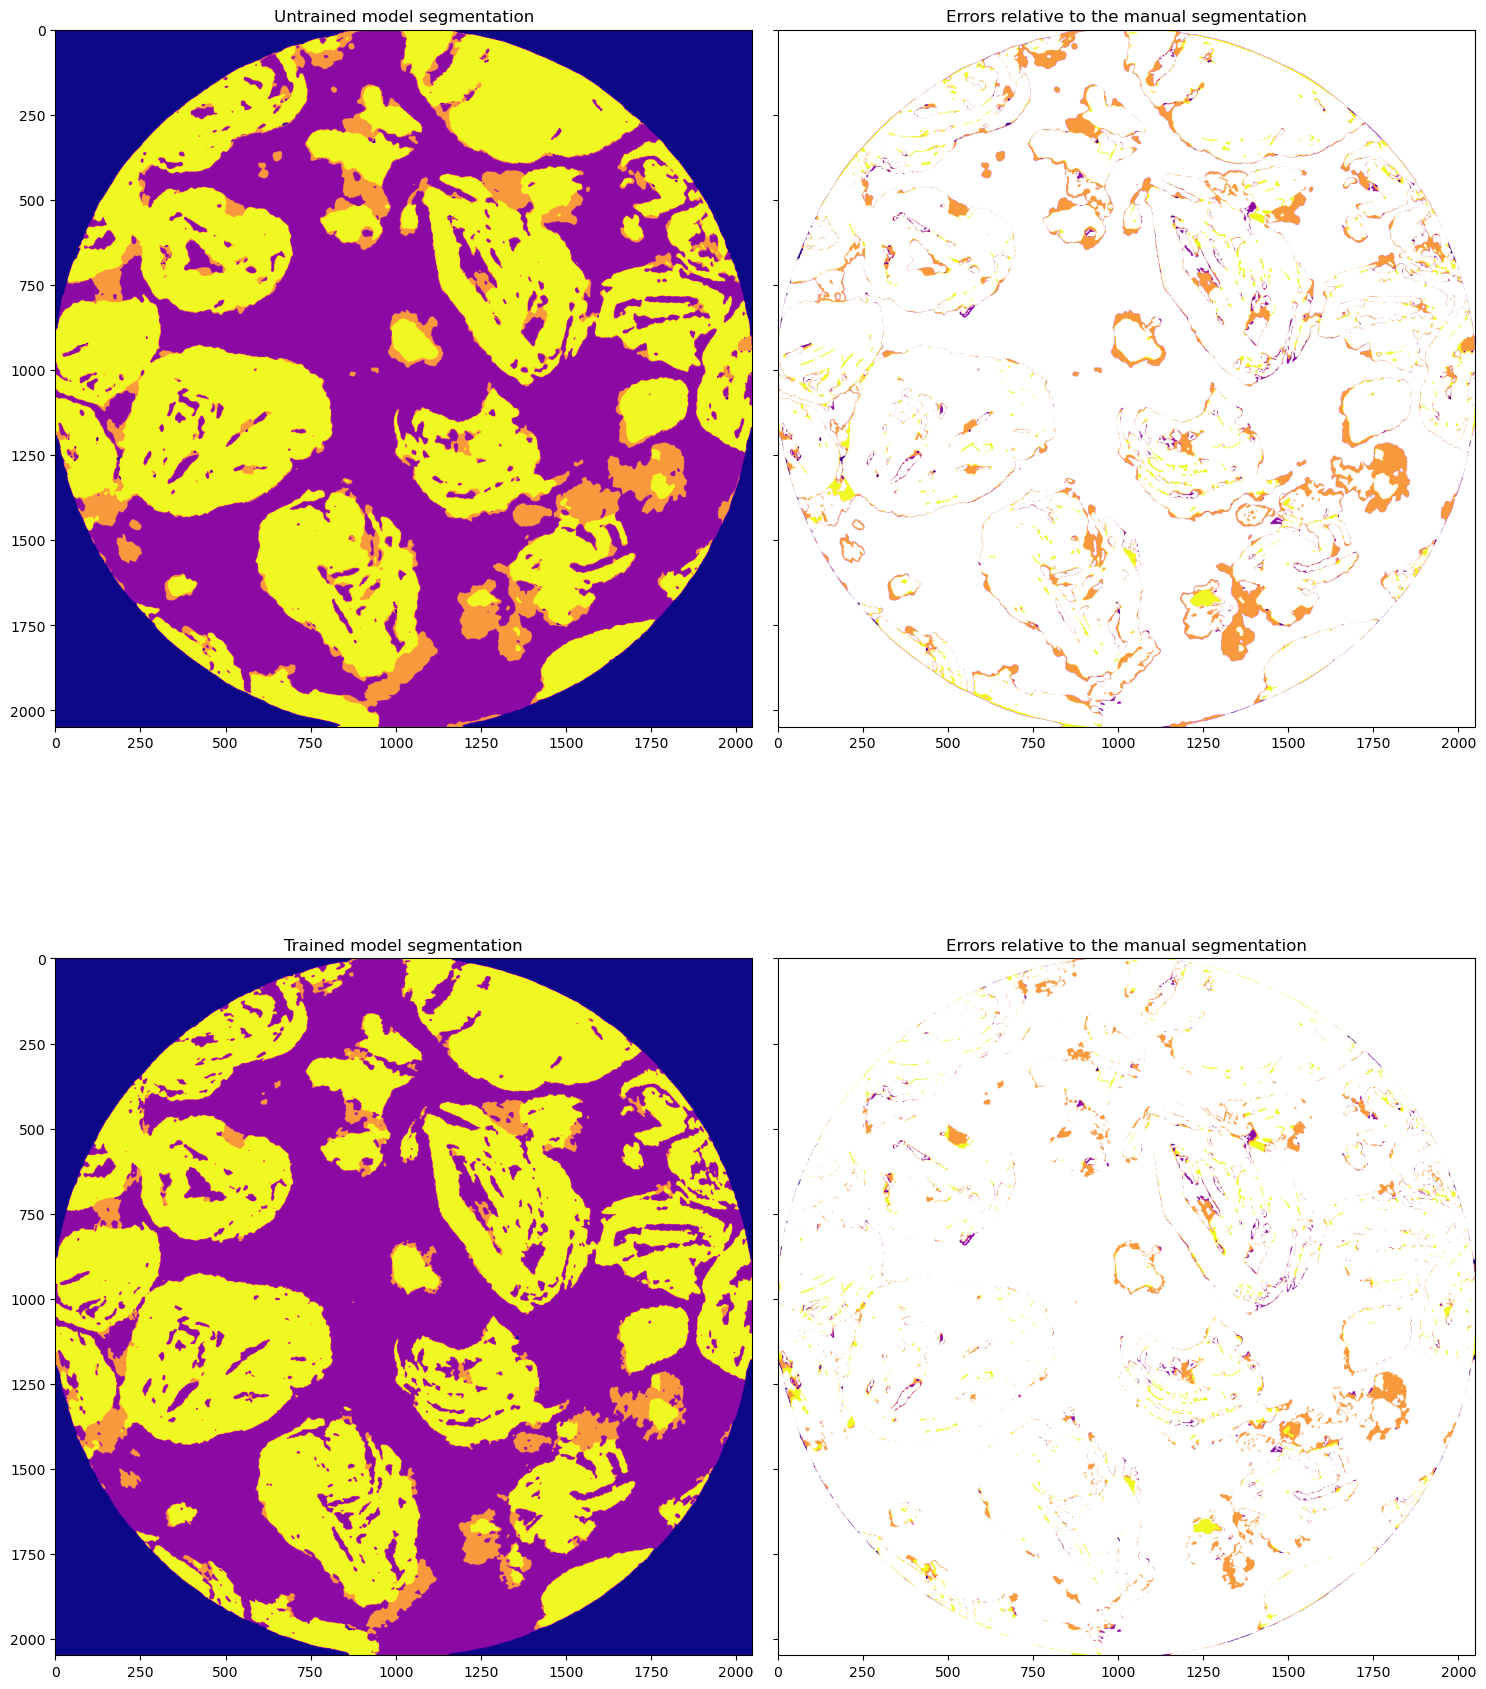

In [17]:
# Differences in segmentation relatively to each phase (maps/images)
image_diff_rough = (image_rough != image_manual)
alpha_mask_rough = image_diff_rough.astype("f")

image_diff_trained = (image_trained != image_manual)
alpha_mask_trained = image_diff_trained.astype("f")

cmap = "plasma"
fig4, axes4 = plt.subplots(2, 2, figsize=(15, 20), sharey=True)
axes4[0][0].imshow(image_rough, cmap=cmap, interpolation=None)
axes4[0][0].set_title("Untrained model segmentation")
axes4[0][1].imshow(image_rough, alpha=alpha_mask_rough, cmap=cmap, interpolation=None)
axes4[0][1].set_title("Errors relative to the manual segmentation")
axes4[1][0].imshow(image_trained, cmap=cmap, interpolation=None)
axes4[1][0].set_title("Trained model segmentation")
axes4[1][1].imshow(image_rough, alpha=alpha_mask_trained, cmap=cmap, interpolation=None)
axes4[1][1].set_title("Errors relative to the manual segmentation")
plt.tight_layout()
plt.show()

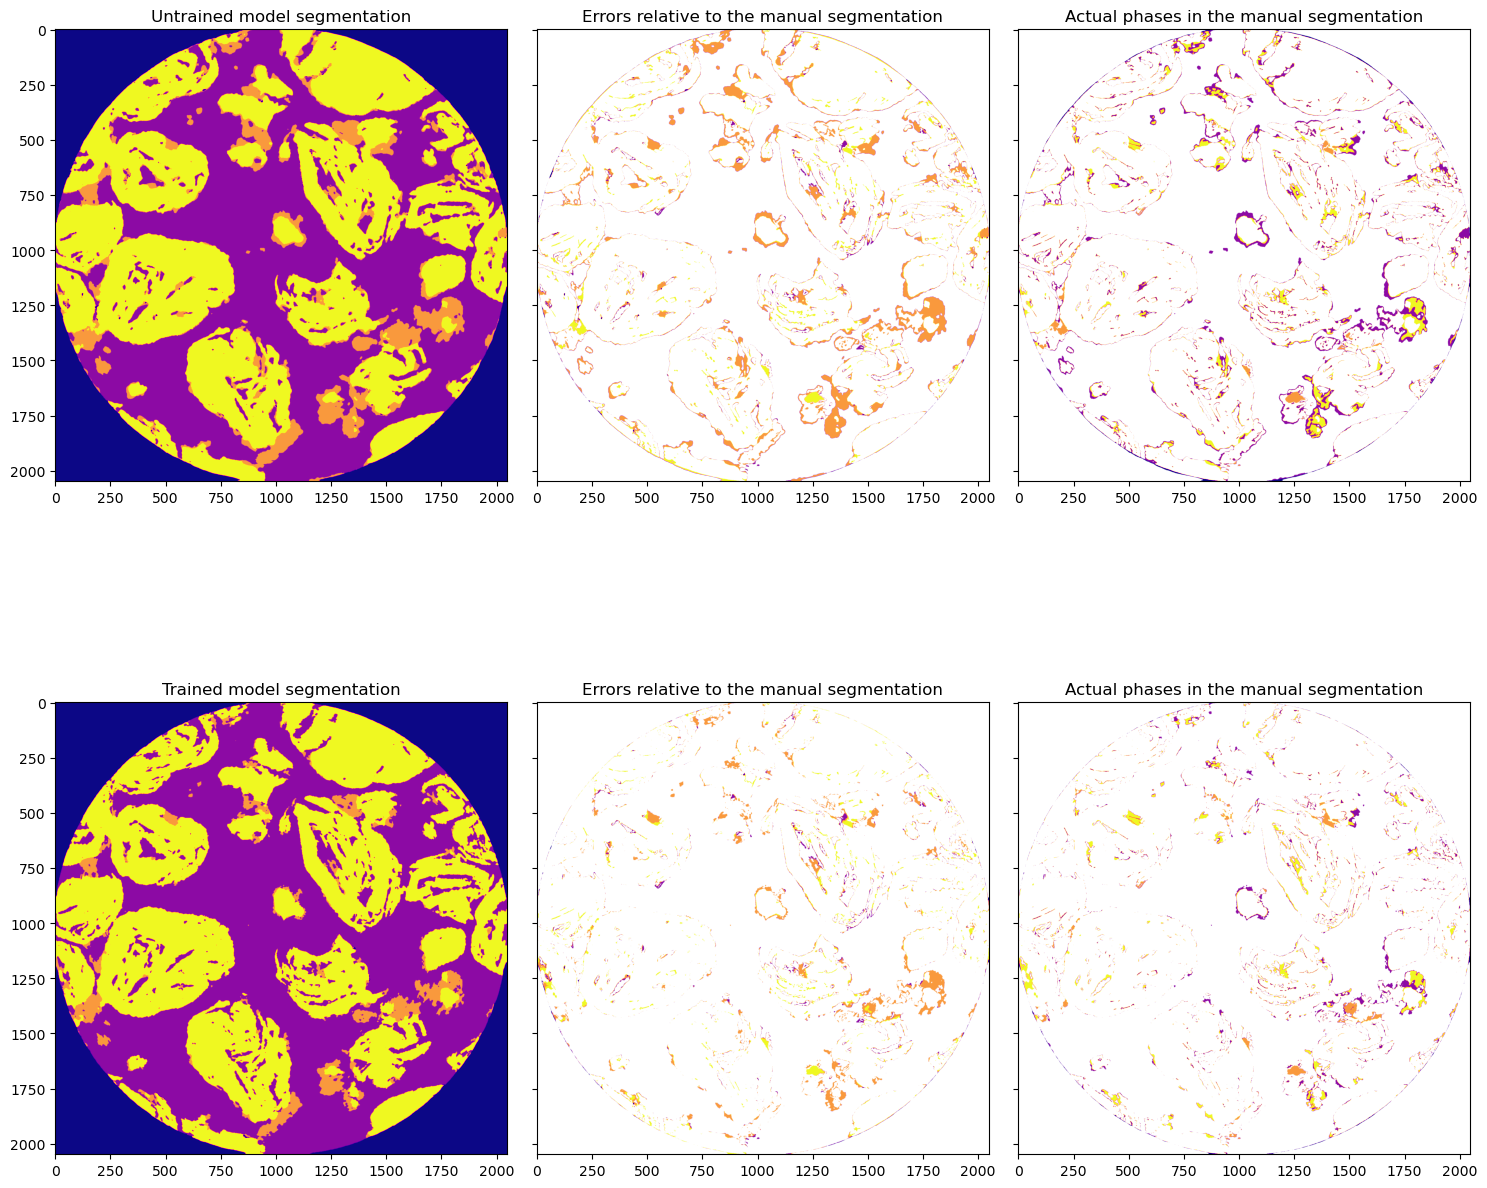

In [18]:
cmap = "plasma"
fig5, axes5 = plt.subplots(2, 3, figsize=(15, 15), sharey=True)
axes5[0][0].imshow(image_rough, cmap=cmap, interpolation=None)
axes5[0][0].set_title("Untrained model segmentation")
axes5[0][1].imshow(image_rough, alpha=alpha_mask_rough, cmap=cmap, interpolation=None)
axes5[0][1].set_title("Errors relative to the manual segmentation")
axes5[0][2].imshow(image_manual, alpha=alpha_mask_rough, cmap=cmap, interpolation=None)
axes5[0][2].set_title("Actual phases in the manual segmentation")
axes5[1][0].imshow(image_trained, cmap=cmap, interpolation=None)
axes5[1][0].set_title("Trained model segmentation")
axes5[1][1].imshow(image_rough, alpha=alpha_mask_trained, cmap=cmap, interpolation=None)
axes5[1][1].set_title("Errors relative to the manual segmentation")
axes5[1][2].imshow(image_manual, alpha=alpha_mask_trained, cmap=cmap, interpolation=None)
axes5[1][2].set_title("Actual phases in the manual segmentation")
plt.tight_layout()
plt.show()

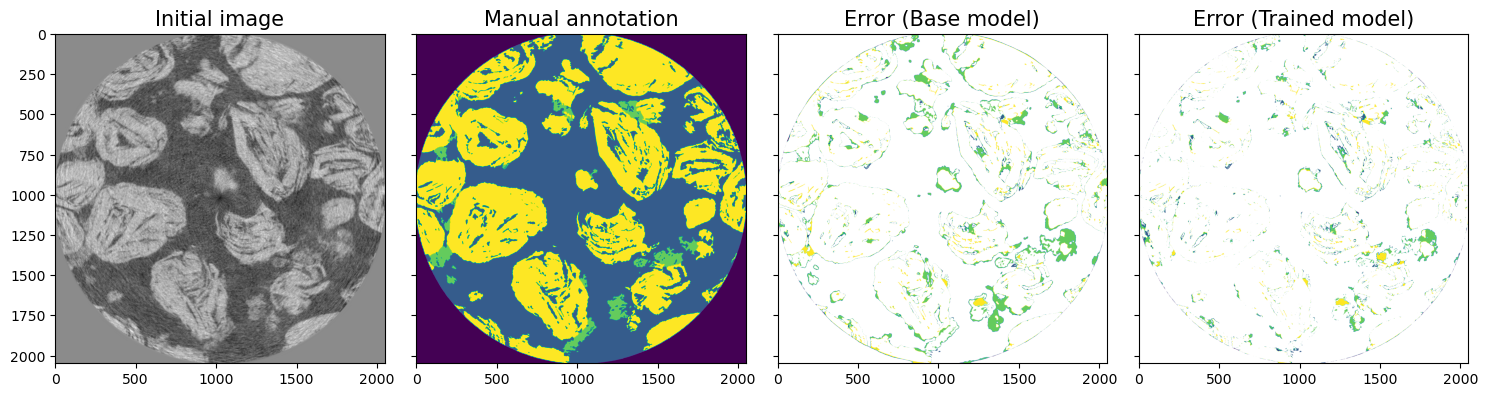

In [20]:
# Global visualistaion of the initial image and the outputs from the three segmentations
cmap = "viridis"
fig1, axes1 = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
axes1[0].imshow(image_initial, cmap="gray", interpolation=None)
axes1[0].set_title("Initial image", fontsize=15)
axes1[1].imshow(image_manual, cmap="viridis", interpolation=None)
axes1[1].set_title("Manual annotation", fontsize=15)
axes1[2].imshow(image_rough, alpha=alpha_mask_rough, cmap=cmap, interpolation=None)
axes1[2].set_title("Error (Base model)", fontsize=15)
axes1[3].imshow(image_trained, alpha=alpha_mask_trained, cmap=cmap, interpolation=None)
axes1[3].set_title("Error (Trained model)", fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig("segmentation_comparison.png")

In [22]:
# Differences in segmentation relatively to each phase (numbers)
am_manual = float(data_manual["pixel count"][data_manual["value"]==242])
am_rough = float(data_rough["pixel count"][data_rough["value"]==242])
am_trained = float(data_trained["pixel count"][data_trained["value"]==242])

relative_difference_rough = (am_rough - am_manual) / am_manual
relative_difference_trained = (am_trained - am_manual) / am_manual
relative_difference_training = (am_rough - am_trained) / am_trained

print("""Relative differences comming from wrongly labelling phases in the images:
- Regarding the active material (graphite):
    Untrained model vs. manual segmentation: {:.2%}
    Trained model vs. manual segmentation: {:.2%}
    Untrained vs. trained model: {:.2%}
""".format(relative_difference_rough, relative_difference_trained, relative_difference_training))

cb_manual = float(data_manual["pixel count"][data_manual["value"]==191])
cb_rough = float(data_rough["pixel count"][data_rough["value"]==191])
cb_trained = float(data_trained["pixel count"][data_trained["value"]==191])

relative_difference_rough = (cb_rough - cb_manual) / cb_manual
relative_difference_trained = (cb_trained - cb_manual) / cb_manual
relative_difference_training = (cb_rough - cb_trained) / cb_trained

print("""- Regarding the conductive binder:
    Untrained model vs. manual segmentation: {:.2%}
    Trained model vs. manual segmentation: {:.2%}
    Untrained vs. trained model: {:.2%}
""".format(relative_difference_rough, relative_difference_trained, relative_difference_training))

poro_manual = float(data_manual["pixel count"][data_manual["value"]==89])
poro_rough = float(data_rough["pixel count"][data_rough["value"]==89])
poro_trained = float(data_trained["pixel count"][data_trained["value"]==89])

relative_difference_rough = (poro_rough - poro_manual) / poro_manual
relative_difference_trained = (poro_trained - poro_manual) / poro_manual
relative_difference_training = (poro_rough - poro_trained) / poro_trained

print("""- Regarding the porosity:
    Untrained model vs. manual segmentation: {:.2%}
    Trained model vs. manual segmentation: {:.2%}
    Untrained vs. trained model: {:.2%}
""".format(relative_difference_rough, relative_difference_trained, relative_difference_training))


Relative differences comming from wrongly labelling phases in the images:
- Regarding the active material (graphite):
    Untrained model vs. manual segmentation: -1.44%
    Trained model vs. manual segmentation: -0.50%
    Untrained vs. trained model: -0.95%

- Regarding the conductive binder:
    Untrained model vs. manual segmentation: 181.15%
    Trained model vs. manual segmentation: 47.29%
    Untrained vs. trained model: 90.89%

- Regarding the porosity:
    Untrained model vs. manual segmentation: -8.82%
    Trained model vs. manual segmentation: -2.09%
    Untrained vs. trained model: -6.87%



C:\Users\lauri\AppData\Local\Temp\ipykernel_23680\1422178935.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  am_manual = float(data_manual["pixel count"][data_manual["value"]==242])
C:\Users\lauri\AppData\Local\Temp\ipykernel_23680\1422178935.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  am_rough = float(data_rough["pixel count"][data_rough["value"]==242])
C:\Users\lauri\AppData\Local\Temp\ipykernel_23680\1422178935.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated Nu

In [23]:
# Save phase fraction and pixel count data as .csv files per segmentaion
df_rough = pd.DataFrame(data_rough)
df_rough.to_csv("Rough_segmentation.csv")

df_trained = pd.DataFrame(data_trained)
df_trained.to_csv("Trained_segmentation.csv")

df_manual = pd.DataFrame(data_manual)
df_manual.to_csv("Manual_segmentation.csv")

# Model comparison between untrained and trained with two other randomly selected slices and their adjacent slices (no manual annotation as ground truth)

In [24]:
images_rough_1093 = io.imread("output_5272987912_s1093/*.tif")
images_rough_724 = io.imread("output_5272987912_s724/*.tif")
images_rough_1507 = io.imread("output_5272987912_s1507/*.tif")